In [51]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [52]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random

In [53]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [54]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [55]:
tf.keras.backend.clear_session()

In [56]:
subject = 'Mato Grosso Do Sul - Consumo de Cimento (t)'
start_index = 0
split_index = 203

window_size = 36
train_split = split_index + 1 - 12

In [57]:
data = pd.read_csv('2003_mo_model_input_MS.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Mato Grosso Do Sul - Consumo de Cimento (t),Mato Grosso do Sul- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso do Sul - IDH,Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - IDH Educacao,Mato Grosso do Sul - IDH Longevidade,Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - PIB - Per Capita,Mato Grosso do Sul - PIB - Preços de Mercado,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,33.744,10575.832000,3.127511,951.776390,1411.785524,24.741737,18.860002,72.032926,3.117091,0.741626,53.166560,0.670882,0.795565,8.248824,0.282837,4.562945e+07,2.151917e+06,16.203179,3.957545e+07,1.583944e+06,0.781096,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,32.230,10674.618538,3.124972,952.492950,1417.150685,24.087997,17.858746,70.442692,3.134253,0.741710,53.245714,0.671146,0.795878,8.242935,0.284487,4.568706e+07,2.153542e+06,16.206131,3.959155e+07,1.591665e+06,0.780750,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,33.559,10766.098168,2.985641,953.076971,1387.889369,23.538968,16.806765,68.403583,3.225807,0.741794,52.994640,0.671410,0.796192,8.237046,0.285379,4.574467e+07,2.155168e+06,16.209084,3.960765e+07,1.599385e+06,0.780403,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,34.283,10853.134597,2.615077,953.978721,1365.688397,22.897246,15.218196,64.880324,3.365984,0.741878,53.019283,0.671673,0.796506,8.231157,0.286089,4.580228e+07,2.156794e+06,16.212036,3.962375e+07,1.607106e+06,0.780057,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,36.066,10952.713907,2.488609,954.723605,1361.257638,22.059134,13.316197,61.056254,3.546947,0.741962,53.539593,0.671937,0.796820,8.225268,0.286122,4.585990e+07,2.158419e+06,16.214989,3.963985e+07,1.614826e+06,0.779710,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2002-8,NaN,NaN,2.658799,953.010197,1389.843663,24.164653,14.249012,57.849305,4.247241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,2002-9,NaN,NaN,2.641716,952.337589,1442.950201,24.585985,15.370194,59.903115,4.169688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,2002-10,NaN,NaN,2.858744,951.610669,1450.895260,25.150173,17.022021,63.836608,3.862138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,2002-11,NaN,NaN,2.964151,951.513490,1468.604568,25.132801,17.963946,67.311116,3.498752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


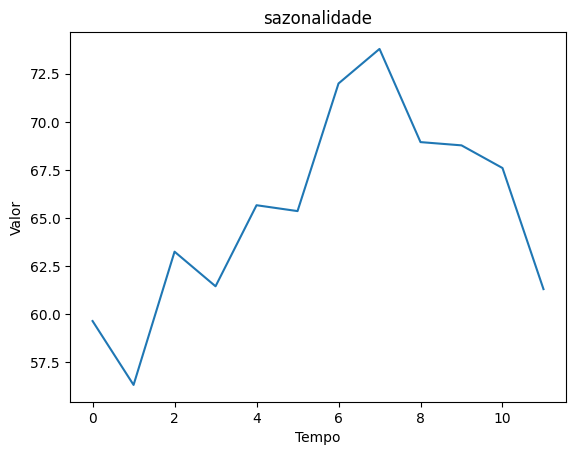

,sazonalidade
sazonalidade,
0,59.644986
1,56.324068
2,63.249819
3,61.450489
4,65.664059
5,65.359131
6,71.992443
7,73.788760
8,68.945228


In [58]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [59]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Mato Grosso do Sul- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso do Sul - IDH,Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - IDH Educacao,Mato Grosso do Sul - IDH Longevidade,Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - PIB - Per Capita,Mato Grosso do Sul - PIB - Preços de Mercado,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Mato Grosso Do Sul - Consumo de Cimento (t)
0,2003-1,10575.832000,3.127511,951.776390,1411.785524,24.741737,18.860002,72.032926,3.117091,0.741626,53.166560,0.670882,0.795565,8.248824,0.282837,4.562945e+07,2.151917e+06,16.203179,3.957545e+07,1.583944e+06,0.781096,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,59.644986,33.744
1,2003-2,10674.618538,3.124972,952.492950,1417.150685,24.087997,17.858746,70.442692,3.134253,0.741710,53.245714,0.671146,0.795878,8.242935,0.284487,4.568706e+07,2.153542e+06,16.206131,3.959155e+07,1.591665e+06,0.780750,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,56.324068,32.230
2,2003-3,10766.098168,2.985641,953.076971,1387.889369,23.538968,16.806765,68.403583,3.225807,0.741794,52.994640,0.671410,0.796192,8.237046,0.285379,4.574467e+07,2.155168e+06,16.209084,3.960765e+07,1.599385e+06,0.780403,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,63.249819,33.559
3,2003-4,10853.134597,2.615077,953.978721,1365.688397,22.897246,15.218196,64.880324,3.365984,0.741878,53.019283,0.671673,0.796506,8.231157,0.286089,4.580228e+07,2.156794e+06,16.212036,3.962375e+07,1.607106e+06,0.780057,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,61.450489,34.283
4,2003-5,10952.713907,2.488609,954.723605,1361.257638,22.059134,13.316197,61.056254,3.546947,0.741962,53.539593,0.671937,0.796820,8.225268,0.286122,4.585990e+07,2.158419e+06,16.214989,3.963985e+07,1.614826e+06,0.779710,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,65.664059,36.066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2002-8,NaN,2.658799,953.010197,1389.843663,24.164653,14.249012,57.849305,4.247241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.664059,NaN
257,2002-9,NaN,2.641716,952.337589,1442.950201,24.585985,15.370194,59.903115,4.169688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.359131,NaN
258,2002-10,NaN,2.858744,951.610669,1450.895260,25.150173,17.022021,63.836608,3.862138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.992443,NaN
259,2002-11,NaN,2.964151,951.513490,1468.604568,25.132801,17.963946,67.311116,3.498752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [60]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      33.550
1      33.682
2      40.149
3      39.205
4      38.897
        ...  
256       NaN
257       NaN
258       NaN
259       NaN
260       NaN
Name: Mato Grosso Do Sul - Consumo de Cimento (t), Length: 261, dtype: float64

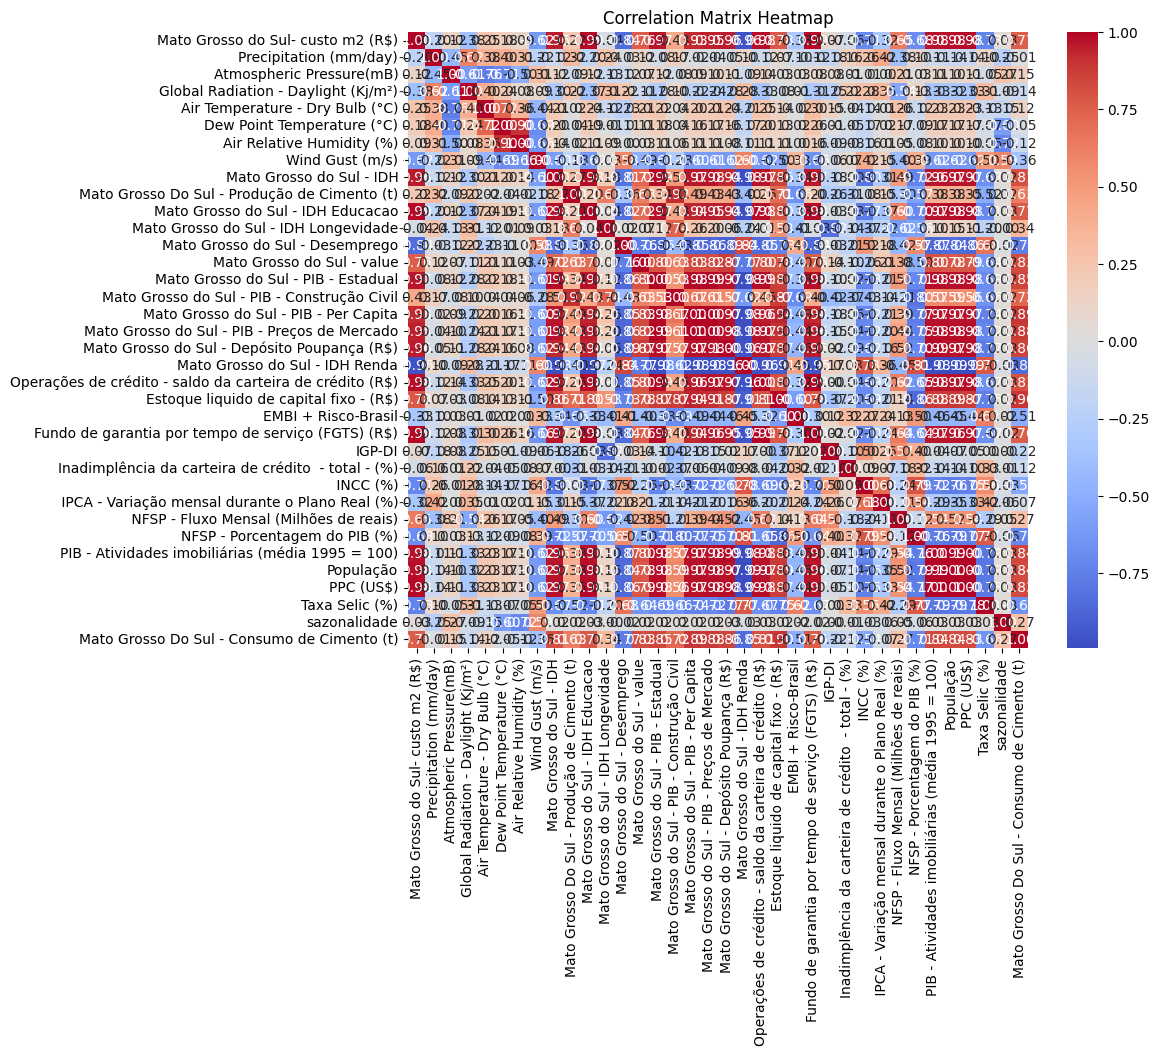

In [61]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [63]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Mato Grosso do Sul- custo m2 (R$),8.147589e+05
1,Precipitation (mm/day),6.284142e+00
2,Atmospheric Pressure(mB),2.224659e+01
3,Global Radiation - Daylight (Kj/m²),1.349180e+01
4,Air Temperature - Dry Bulb (°C),1.614166e+02
5,Dew Point Temperature (°C),6.918299e+02
6,Air Relative Humidity (%),3.894013e+02
7,Wind Gust (m/s),2.029871e+01
8,Mato Grosso do Sul - IDH,9.697930e+08
9,Mato Grosso Do Sul - Produção de Cimento (t),7.676951e+04


In [64]:
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


,Mato Grosso do Sul- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,10575.832000,3.127511,1411.785524,24.741737,18.860002,72.032926,3.117091,53.166560,8.248824,0.282837,4.562945e+07,1.583944e+06,0.781096,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,59.644986
1,10674.618538,3.124972,1417.150685,24.087997,17.858746,70.442692,3.134253,53.245714,8.242935,0.284487,4.568706e+07,1.591665e+06,0.780750,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,56.324068
2,10766.098168,2.985641,1387.889369,23.538968,16.806765,68.403583,3.225807,52.994640,8.237046,0.285379,4.574467e+07,1.599385e+06,0.780403,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,63.249819
3,10853.134597,2.615077,1365.688397,22.897246,15.218196,64.880324,3.365984,53.019283,8.231157,0.286089,4.580228e+07,1.607106e+06,0.780057,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,61.450489
4,10952.713907,2.488609,1361.257638,22.059134,13.316197,61.056254,3.546947,53.539593,8.225268,0.286122,4.585990e+07,1.614826e+06,0.779710,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,65.664059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,26409.237585,1.548632,1300.085884,24.791286,14.260905,56.331120,3.261307,64.572632,6.748760,0.366082,5.590239e+07,3.928453e+06,0.744508,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,73.788760
200,26634.127777,1.929452,1361.147572,25.307472,15.532776,59.239395,3.048192,64.992770,6.736443,0.371560,5.585349e+07,3.969532e+06,0.744468,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,68.945228
201,26860.698524,2.228653,1420.388034,25.466213,16.879296,63.023672,2.808008,65.509657,6.724127,0.377270,5.580459e+07,4.010611e+06,0.744429,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,68.776230
202,27095.144602,2.644884,1441.013050,25.473158,18.024171,67.093017,2.594395,65.990777,6.711810,0.383216,5.575570e+07,4.051690e+06,0.744389,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,67.598312


In [65]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,1.267503,0.320304,1.059436,1.381609,1.197276,-0.368244,-1.452341,1.268289,-0.523736,-1.697432,-1.538130,2.158106,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,1.262062,0.364264,0.411806,0.881720,0.878985,-0.324617,-1.443527,1.258202,-0.487144,-1.682483,-1.528310,2.127396,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,0.963597,0.124506,-0.132093,0.356506,0.470851,-0.091871,-1.471486,1.248115,-0.467365,-1.667535,-1.518490,2.096686,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,0.169799,-0.057402,-0.767818,-0.436606,-0.234341,0.264483,-1.468742,1.238027,-0.451632,-1.652586,-1.508670,2.065976,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-0.101113,-0.093706,-1.598099,-1.386201,-0.999740,0.724518,-1.410802,1.227940,-0.450898,-1.637638,-1.498850,2.035266,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-2.114669,-0.594928,1.108523,-0.914544,-1.945491,-0.001624,-0.182192,-1.301129,1.321673,0.968139,1.443969,-1.084429,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268
200,-1.298900,-0.094608,1.619885,-0.279548,-1.363391,-0.543396,-0.135406,-1.322226,1.443113,0.955452,1.496219,-1.087931,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925
201,-0.657972,0.390790,1.777142,0.392718,-0.605955,-1.153985,-0.077847,-1.343323,1.569692,0.942764,1.548470,-1.091433,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663
202,0.233649,0.559785,1.784023,0.964310,0.208537,-1.697021,-0.024271,-1.364419,1.701510,0.930077,1.600720,-1.094935,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340


In [66]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,1.267503,0.320304,1.059436,1.381609,1.197276,-0.368244,-1.452341,1.268289,-0.523736,-1.697432,-1.538130,2.158106,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,1.262062,0.364264,0.411806,0.881720,0.878985,-0.324617,-1.443527,1.258202,-0.487144,-1.682483,-1.528310,2.127396,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,0.963597,0.124506,-0.132093,0.356506,0.470851,-0.091871,-1.471486,1.248115,-0.467365,-1.667535,-1.518490,2.096686,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,0.169799,-0.057402,-0.767818,-0.436606,-0.234341,0.264483,-1.468742,1.238027,-0.451632,-1.652586,-1.508670,2.065976,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-0.101113,-0.093706,-1.598099,-1.386201,-0.999740,0.724518,-1.410802,1.227940,-0.450898,-1.637638,-1.498850,2.035266,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-2.394816,-3.118807,-0.556256,-0.524597,-0.308159,-0.344258,-0.835634,-1.098500,0.237045,1.108400,1.074503,-1.080793,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820
188,-2.631498,-3.520493,0.243640,0.111706,0.020791,-0.704483,-0.802854,-1.109490,0.303197,1.098110,1.075246,-1.076618,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503
189,-2.344766,-3.457987,0.913924,0.756585,0.414801,-1.007191,-0.711911,-1.120480,0.370515,1.087820,1.075988,-1.072443,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444
190,-1.682405,-2.975086,1.191844,1.058229,0.662472,-1.340574,-0.635171,-1.131471,0.445429,1.077530,1.076731,-1.068268,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935


In [67]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       33.550
1       33.682
2       40.149
3       39.205
4       38.897
        ...   
187    101.373
188     97.514
189    109.191
190     97.506
191     68.585
Name: Mato Grosso Do Sul - Consumo de Cimento (t), Length: 192, dtype: float64

In [68]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [69]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 24)

In [70]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
156,0.608223,0.133651,1.387394,1.481211,1.142332,-1.413727,-0.193724,-0.300549,0.546395,1.140673,0.615863,-1.266359,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265
157,0.806022,-0.064415,0.800267,1.200335,1.110131,-1.434955,-0.292735,-0.346239,0.501826,1.144514,0.633315,-1.255312,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084
158,0.424051,-0.450779,-0.154386,0.598769,0.863444,-1.127431,-0.376257,-0.391930,0.465347,1.148356,0.650767,-1.244264,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087
159,-0.117247,-0.726533,-0.876811,-0.108825,0.283080,-0.748658,-0.424134,-0.437621,0.429009,1.152197,0.668219,-1.233217,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300
160,-0.381356,-1.069953,-1.533035,-0.644912,-0.075444,-0.325928,-0.488677,-0.483312,0.388229,1.156038,0.685670,-1.222170,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403
161,-1.248706,-0.646732,-1.582915,-0.990873,-0.628936,0.021532,-0.526412,-0.529003,0.350238,1.159879,0.703122,-1.211122,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434
162,-1.204152,-0.101792,-1.011522,-0.766830,-0.759304,0.255953,-0.555266,-0.574693,0.314921,1.163720,0.720574,-1.200075,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553
163,-1.149768,0.231342,-0.430136,-0.185525,-0.323968,0.231439,-0.587650,-0.620384,0.280951,1.167562,0.738026,-1.189028,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038
164,-1.056549,0.481382,0.027642,0.374590,0.205035,0.054968,-0.640317,-0.666075,0.250052,1.171403,0.755478,-1.177981,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412
165,-0.491945,0.618824,0.552156,0.994908,0.811411,-0.359239,-0.707180,-0.711766,0.224477,1.175244,0.772929,-1.166933,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764


In [71]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [72]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [73]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [74]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [75]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[47365551, 2044123462, 2888306631, 4198075910, 2663647162, 826316773, 469612472, 2149038217, 3550099430, 2386147995]


Step: 0 ___________________________________________
val_loss: 149.50694274902344
winner_seed: 47365551


Step: 1 ___________________________________________
val_loss: 194.533935546875


Step: 2 ___________________________________________
val_loss: 122.6167984008789
winner_seed: 2888306631


Step: 3 ___________________________________________
val_loss: 189.6454620361328


Step: 4 ___________________________________________
val_loss: 153.28240966796875


Step: 5 ___________________________________________
val_loss: 199.17355346679688


Step: 6 ___________________________________________
val_loss: 161.32237243652344


Step: 7 ___________________________________________
val_loss: 150.14051818847656


Step: 8 ___________________________________________
val_loss: 171.24966430664062


Step: 9 ___________________________________________
val_loss: 174.57260131835938


final_see

In [76]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 97ms/step - loss: 4607.2856 - val_loss: 1270.1478
Epoch 2/10000
5/5 [==============================] - 0s 10ms/step - loss: 364.9995 - val_loss: 326.1728
Epoch 3/10000
5/5 [==============================] - 0s 10ms/step - loss: 127.1693 - val_loss: 260.0289
Epoch 4/10000
5/5 [==============================] - 0s 11ms/step - loss: 121.1669 - val_loss: 268.5723
Epoch 5/10000
5/5 [==============================] - 0s 10ms/step - loss: 111.1239 - val_loss: 264.8774
Epoch 6/10000
5/5 [==============================] - 0s 10ms/step - loss: 94.4287 - val_loss: 231.8891
Epoch 7/10000
5/5 [==============================] - 0s 9ms/step - loss: 79.7440 - val_loss: 226.1364
Epoch 8/10000
5/5 [==============================] - 0s 9ms/step - loss: 75.0093 - val_loss: 222.9621
Epoch 9/10000
5/5 [==============================] - 0s 9ms/step - loss: 67.8746 - val_loss: 263.4460
Epoch 10/10000
5/5 [==============================] - 0s 9ms/step - l

5/5 [==============================] - 0s 9ms/step - loss: 21.3864 - val_loss: 136.3529
Epoch 81/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.8039 - val_loss: 142.8420
Epoch 82/10000
5/5 [==============================] - 0s 9ms/step - loss: 20.1599 - val_loss: 139.5075
Epoch 83/10000
5/5 [==============================] - 0s 10ms/step - loss: 22.0729 - val_loss: 136.6079
Epoch 84/10000
5/5 [==============================] - 0s 10ms/step - loss: 22.6361 - val_loss: 160.3268
Epoch 85/10000
5/5 [==============================] - 0s 10ms/step - loss: 22.8635 - val_loss: 133.9736
Epoch 86/10000
5/5 [==============================] - 0s 10ms/step - loss: 21.7298 - val_loss: 143.3096
Epoch 87/10000
5/5 [==============================] - 0s 10ms/step - loss: 22.2450 - val_loss: 148.0200
Epoch 88/10000
5/5 [==============================] - 0s 11ms/step - loss: 20.6568 - val_loss: 144.9276
Epoch 89/10000
5/5 [==============================] - 0s 11ms/step - loss: 19.9041

5/5 [==============================] - 0s 9ms/step - loss: 24.0742 - val_loss: 143.5608
Epoch 159/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.6638 - val_loss: 136.7840
Epoch 160/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.9889 - val_loss: 129.9878
Epoch 161/10000
5/5 [==============================] - 0s 8ms/step - loss: 18.3424 - val_loss: 131.8730
Epoch 162/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.0429 - val_loss: 130.2384
Epoch 163/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.1909 - val_loss: 130.4799
Epoch 164/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.8887 - val_loss: 131.9915
Epoch 165/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.9742 - val_loss: 133.9895
Epoch 166/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.1435 - val_loss: 137.5052
Epoch 167/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.73

5/5 [==============================] - 0s 9ms/step - loss: 15.4559 - val_loss: 139.5458
Epoch 237/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.2204 - val_loss: 132.8340
Epoch 238/10000
5/5 [==============================] - 0s 10ms/step - loss: 17.1774 - val_loss: 134.7629
Epoch 239/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.3233 - val_loss: 129.3880
Epoch 240/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.8068 - val_loss: 136.5869
Epoch 241/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.1390 - val_loss: 130.3851
Epoch 242/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.8873 - val_loss: 140.3447
Epoch 243/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.9859 - val_loss: 138.7255
Epoch 244/10000
5/5 [==============================] - 0s 10ms/step - loss: 16.7720 - val_loss: 153.9156
Epoch 245/10000
5/5 [==============================] - 0s 11ms/step - loss: 18

5/5 [==============================] - 0s 10ms/step - loss: 16.1009 - val_loss: 130.9467
Epoch 315/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.2913 - val_loss: 136.1955
Epoch 316/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.4183 - val_loss: 144.7326
Epoch 317/10000
5/5 [==============================] - 0s 10ms/step - loss: 17.4379 - val_loss: 136.9302
Epoch 318/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.8333 - val_loss: 130.2451
Epoch 319/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.0286 - val_loss: 139.4328
Epoch 320/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.4329 - val_loss: 134.4929
Epoch 321/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.7063 - val_loss: 139.9138
Epoch 322/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.9006 - val_loss: 136.5031
Epoch 323/10000
5/5 [==============================] - 0s 9ms/step - loss: 15

Epoch 393/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.4390 - val_loss: 124.2845
Epoch 394/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.8087 - val_loss: 139.6937
Epoch 395/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.9890 - val_loss: 135.1418
Epoch 396/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.5368 - val_loss: 133.3556
Epoch 397/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.6002 - val_loss: 157.3036
Epoch 398/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.4229 - val_loss: 125.3133
Epoch 399/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.7231 - val_loss: 146.4856
Epoch 400/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.0994 - val_loss: 140.1180
Epoch 401/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.4003 - val_loss: 137.1789
Epoch 402/10000
5/5 [==============================] - 0s 9ms/s

5/5 [==============================] - 0s 9ms/step - loss: 13.5948 - val_loss: 150.3694
Epoch 472/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.0737 - val_loss: 151.3309
Epoch 473/10000
5/5 [==============================] - 0s 8ms/step - loss: 12.5111 - val_loss: 150.3398
Epoch 474/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.6518 - val_loss: 157.0795
Epoch 475/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.6511 - val_loss: 156.3630
Epoch 476/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.9119 - val_loss: 155.7116
Epoch 477/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.2191 - val_loss: 157.5887
Epoch 478/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.4187 - val_loss: 151.7474
Epoch 479/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.2984 - val_loss: 152.9608
Epoch 480/10000
5/5 [==============================] - 0s 10ms/step - loss

5/5 [==============================] - 0s 9ms/step - loss: 12.1174 - val_loss: 160.0774
Epoch 550/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.3163 - val_loss: 172.4497
Epoch 551/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.0178 - val_loss: 173.8177
Epoch 552/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.6023 - val_loss: 182.2517
Epoch 553/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.3437 - val_loss: 182.5751
Epoch 554/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.7714 - val_loss: 162.9045
Epoch 555/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.8630 - val_loss: 167.7780
Epoch 556/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.8106 - val_loss: 165.8223
Epoch 557/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.8766 - val_loss: 159.9570
Epoch 558/10000
5/5 [==============================] - 0s 9ms/step - loss: 1

Epoch 628/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.3658 - val_loss: 173.9465
Epoch 629/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.6924 - val_loss: 172.1840
Epoch 630/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.6921 - val_loss: 161.6053
Epoch 631/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.2706 - val_loss: 176.6998
Epoch 632/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.3861 - val_loss: 192.4621
Epoch 633/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.1359 - val_loss: 163.5318
Epoch 634/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.1187 - val_loss: 174.3036
Epoch 635/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.8609 - val_loss: 185.8441
Epoch 636/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.0632 - val_loss: 184.9185
Epoch 637/10000
5/5 [==============================] - 0s 9ms/s

Epoch 707/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.6449 - val_loss: 206.0788
Epoch 708/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.1860 - val_loss: 187.3204
Epoch 709/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.0371 - val_loss: 185.7855
Epoch 710/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.0119 - val_loss: 182.2363
Epoch 711/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.9201 - val_loss: 177.9714
Epoch 712/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.5570 - val_loss: 185.2770
Epoch 713/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.6706 - val_loss: 188.2245
Epoch 714/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.0994 - val_loss: 177.4148
Epoch 715/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.2568 - val_loss: 180.0757
Epoch 716/10000
5/5 [==============================] - 0s 9ms/ste

5/5 [==============================] - 0s 10ms/step - loss: 9.9340 - val_loss: 183.2016
Epoch 787/10000
5/5 [==============================] - 0s 11ms/step - loss: 9.1742 - val_loss: 180.6193
Epoch 788/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.9360 - val_loss: 185.8098
Epoch 789/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.5465 - val_loss: 176.1536
Epoch 790/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.0098 - val_loss: 189.1804
Epoch 791/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.5729 - val_loss: 182.2115
Epoch 792/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.6861 - val_loss: 177.3212
Epoch 793/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.2254 - val_loss: 182.4572
Epoch 794/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.8207 - val_loss: 185.2536
Epoch 795/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.24

5/5 [==============================] - 0s 10ms/step - loss: 9.7425 - val_loss: 196.6868
Epoch 866/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.2819 - val_loss: 178.7325
Epoch 867/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.8841 - val_loss: 196.0775
Epoch 868/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.9473 - val_loss: 185.2720
Epoch 869/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.7398 - val_loss: 190.4143
Epoch 870/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.4987 - val_loss: 122.6168
Epoch 871/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.7292 - val_loss: 150.0282
Epoch 872/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.3361 - val_loss: 204.7401
Epoch 873/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.9426 - val_loss: 158.2093
Epoch 874/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.631

5/5 [==============================] - 0s 10ms/step - loss: 8.5961 - val_loss: 183.6221
Epoch 945/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.7633 - val_loss: 199.5525
Epoch 946/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.0140 - val_loss: 192.7427
Epoch 947/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.7378 - val_loss: 202.0901
Epoch 948/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.9068 - val_loss: 193.0901
Epoch 949/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.3330 - val_loss: 191.8931
Epoch 950/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.0692 - val_loss: 188.2236
Epoch 951/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.3776 - val_loss: 199.0763
Epoch 952/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.6520 - val_loss: 185.2420
Epoch 953/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.6085 - va

5/5 [==============================] - 0s 9ms/step - loss: 8.1394 - val_loss: 222.3080
Epoch 1024/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.6191 - val_loss: 203.3261
Epoch 1025/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.3017 - val_loss: 198.8604
Epoch 1026/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.6466 - val_loss: 193.4509
Epoch 1027/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.2094 - val_loss: 196.2251
Epoch 1028/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.1100 - val_loss: 186.7508
Epoch 1029/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.0792 - val_loss: 203.3292
Epoch 1030/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.3985 - val_loss: 204.1304
Epoch 1031/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.4196 - val_loss: 188.6056
Epoch 1032/10000
5/5 [==============================] - 0s 10ms/step - loss

5/5 [==============================] - 0s 9ms/step - loss: 7.9735 - val_loss: 217.3877
Epoch 1102/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.6849 - val_loss: 196.8504
Epoch 1103/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.3533 - val_loss: 177.3386
Epoch 1104/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.3754 - val_loss: 131.4631
Epoch 1105/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.1841 - val_loss: 256.4972
Epoch 1106/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.6660 - val_loss: 240.8549
Epoch 1107/10000
5/5 [==============================] - 0s 11ms/step - loss: 10.0085 - val_loss: 230.0942
Epoch 1108/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.6278 - val_loss: 239.3283
Epoch 1109/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.4942 - val_loss: 236.7315
Epoch 1110/10000
5/5 [==============================] - 0s 10ms/step -

5/5 [==============================] - 0s 9ms/step - loss: 7.5367 - val_loss: 218.1846
Epoch 1180/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.4388 - val_loss: 232.8645
Epoch 1181/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.2264 - val_loss: 235.9875
Epoch 1182/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.5994 - val_loss: 224.2568
Epoch 1183/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.0588 - val_loss: 233.2552
Epoch 1184/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.4626 - val_loss: 231.7060
Epoch 1185/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.0054 - val_loss: 224.2701
Epoch 1186/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.5026 - val_loss: 226.0489
Epoch 1187/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.7411 - val_loss: 218.5372
Epoch 1188/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.2

Epoch 1258/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.4543 - val_loss: 242.8288
Epoch 1259/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.3392 - val_loss: 241.9206
Epoch 1260/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.3967 - val_loss: 233.2164
Epoch 1261/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.4765 - val_loss: 252.8610
Epoch 1262/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.5297 - val_loss: 243.6050
Epoch 1263/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.6161 - val_loss: 252.4233
Epoch 1264/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.0402 - val_loss: 241.9522
Epoch 1265/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.4342 - val_loss: 230.3994
Epoch 1266/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.2475 - val_loss: 233.3117
Epoch 1267/10000
5/5 [==============================] - 0s 8ms

5/5 [==============================] - 0s 10ms/step - loss: 6.5522 - val_loss: 231.4952
Epoch 1337/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.3910 - val_loss: 245.3041
Epoch 1338/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.1359 - val_loss: 237.5367
Epoch 1339/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.8300 - val_loss: 246.8067
Epoch 1340/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.2684 - val_loss: 227.5685
Epoch 1341/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.4892 - val_loss: 235.8120
Epoch 1342/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.6080 - val_loss: 234.6785
Epoch 1343/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.6818 - val_loss: 231.0319
Epoch 1344/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.2583 - val_loss: 227.8562
Epoch 1345/10000
5/5 [==============================] - 0s 9ms/step - loss

In [77]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [78]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,76.911514,73.444534,72.851341,73.426437,77.27935,78.48719,86.427338,83.927856,81.932846,80.692986,76.603874,74.909821
Target,74.556,77.176,96.162,98.07,96.714,87.716,103.907,105.186,98.973,84.574,89.311,79.711
Error,2.355515,3.731468,23.310661,24.643562,19.434647,9.228813,17.47966,21.258141,17.040154,3.881012,12.707123,4.801178


In [79]:
display(mae)
display(mape)

13.322661

0.13922474

In [80]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [81]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[936.89514]] - Target[1092.056]| =  Error: [[155.16089]]; MAPE:[[0.14208144]]


[array([[155.16089]], dtype=float32)]

155.16089

0.14208144